In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import folium
from folium.plugins import HeatMap

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    r2_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from prophet import Prophet
from prophet.plot import plot_plotly

from collections import Counter
from scipy.stats import chi2_contingency

from mpl_chord_diagram import chord_diagram


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("nyc311_10m_clean.csv")

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

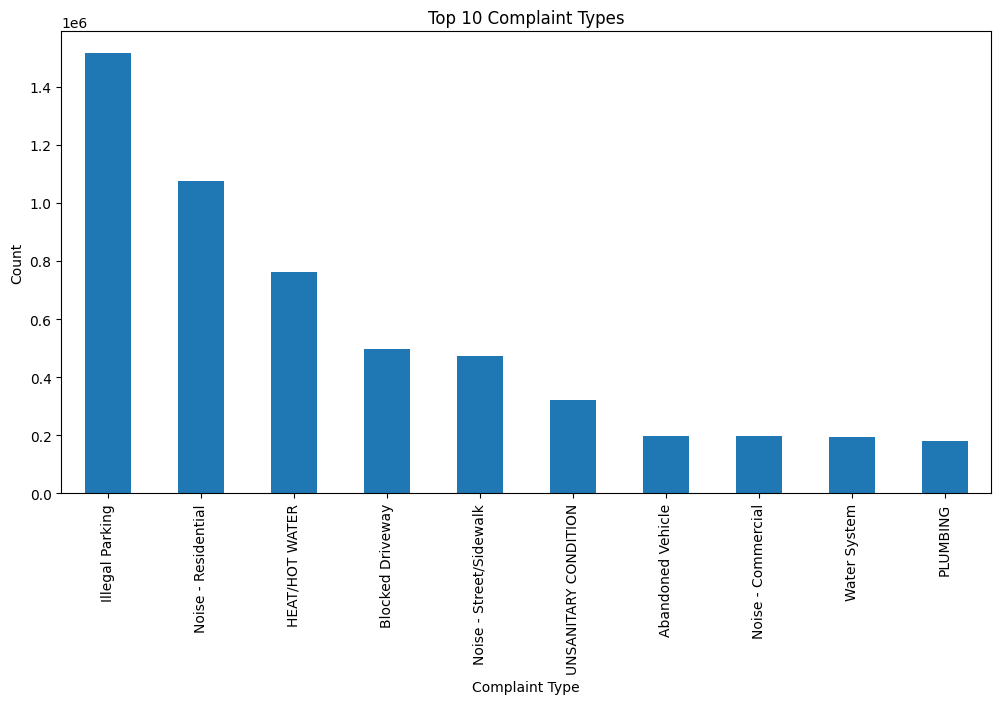

In [4]:
# Complaint type frequency
plt.figure(figsize=(12,6))
df['complaint_type'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Complaint Types")
plt.xlabel("Complaint Type")
plt.ylabel("Count")
plt.show()

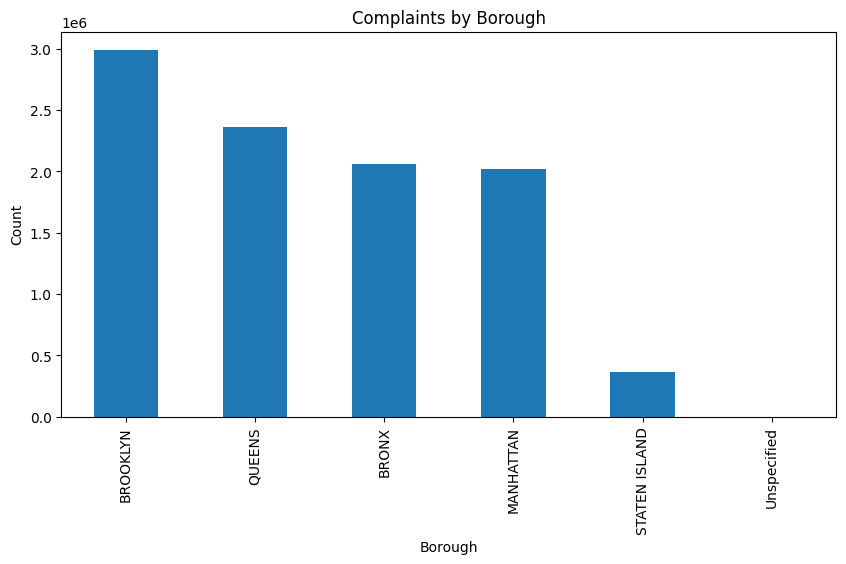

In [5]:
# Complaints by borough
plt.figure(figsize=(10,5))
df['borough'].value_counts().plot(kind='bar')
plt.title("Complaints by Borough")
plt.xlabel("Borough")
plt.ylabel("Count")
plt.show()

In [6]:
# Complaints per capita by borough
borough_population = {
    "BROOKLYN": 2736074,
    "QUEENS": 2405464,
    "MANHATTAN": 1694251,
    "BRONX": 1472654,
    "STATEN ISLAND": 495747
}

complaint_counts = df['borough'].value_counts().rename("complaints")

borough_stats = pd.DataFrame(complaint_counts)

borough_stats["population"] = borough_stats.index.map(borough_population)

borough_stats["complaints_per_1000"] = (
    borough_stats["complaints"] / borough_stats["population"] * 1000
)

borough_stats

complaints  population  complaints_per_1000
borough                                                   
BROOKLYN          2989177   2736074.0          1092.505904
QUEENS            2364975   2405464.0           983.167904
BRONX             2058986   1472654.0          1398.146476
MANHATTAN         2016902   1694251.0          1190.438725
STATEN ISLAND      367278    495747.0           740.857736
Unspecified           516         NaN                  NaN

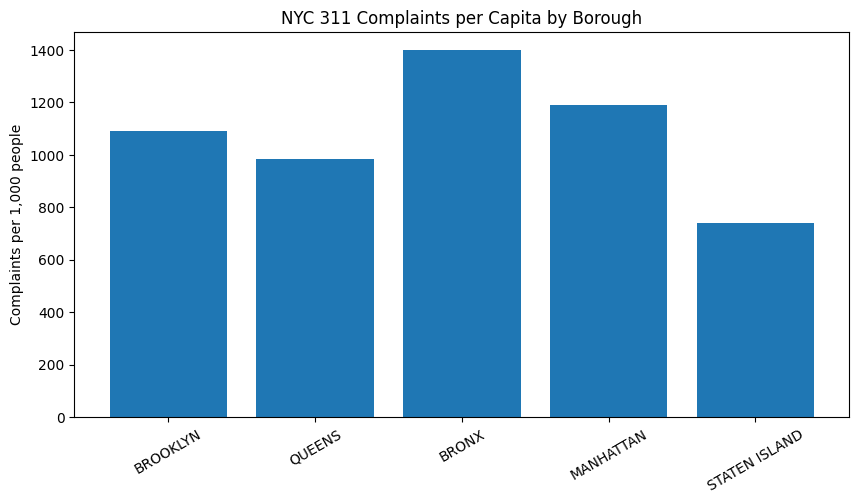

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(borough_stats.index, borough_stats["complaints_per_1000"])
plt.ylabel("Complaints per 1,000 people")
plt.title("NYC 311 Complaints per Capita by Borough")
plt.xticks(rotation=30)
plt.show()


In [8]:
# Correlation between complaints and demographics
demographics = {
    "borough": ["BROOKLYN", "QUEENS", "MANHATTAN", "THE BRONX", "STATEN ISLAND"],
    "median_income": [56942, 64509, 85071, 37397, 79201],
    "bachelor_or_higher_pct": [46.0, 38.8, 68.0, 22.8, 37.3]
}

demo_df = pd.DataFrame(demographics)

complaints_by_borough = (
    df["borough"].value_counts()
    .rename_axis("borough")
    .reset_index(name="total_complaints")
    .dropna()
)

merged_demo = complaints_by_borough.merge(demo_df, on="borough", how="left")
corr = merged_demo[["total_complaints", "median_income", "bachelor_or_higher_pct"]].corr()
corr


total_complaints  median_income  \
total_complaints                1.000000      -0.673161   
median_income                  -0.673161       1.000000   
bachelor_or_higher_pct          0.259464       0.512309   

                        bachelor_or_higher_pct  
total_complaints                      0.259464  
median_income                         0.512309  
bachelor_or_higher_pct                1.000000

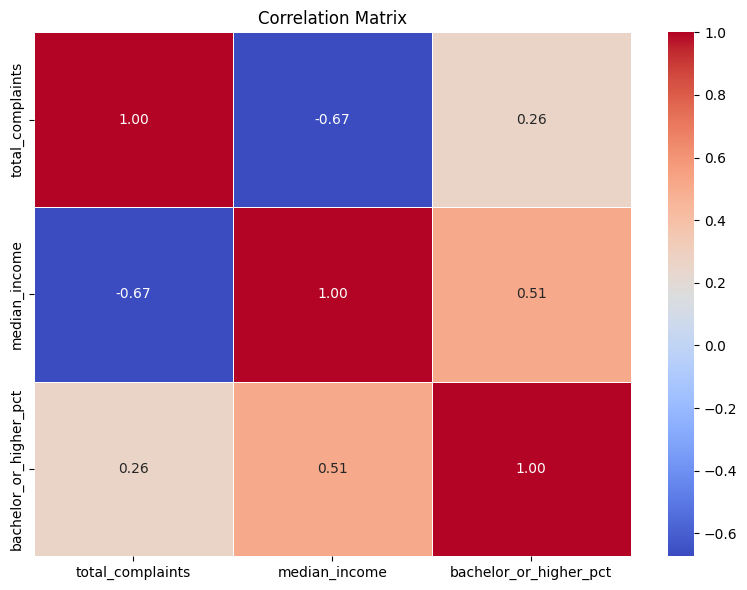

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

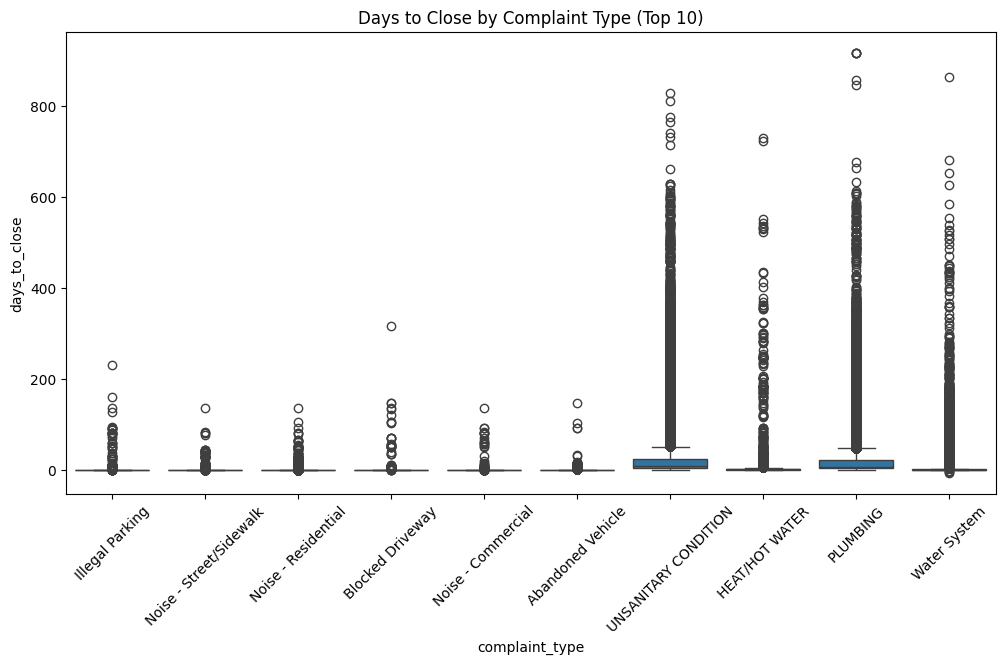

In [10]:
# Days to close by complaint type
if "days_to_close" in df.columns:
    top_types = df['complaint_type'].value_counts().head(10).index
    subset = df[df['complaint_type'].isin(top_types)]
    plt.figure(figsize=(12,6))
    sns.boxplot(data=subset, x="complaint_type", y="days_to_close")
    plt.xticks(rotation=45)
    plt.title("Days to Close by Complaint Type (Top 10)")
    plt.show()

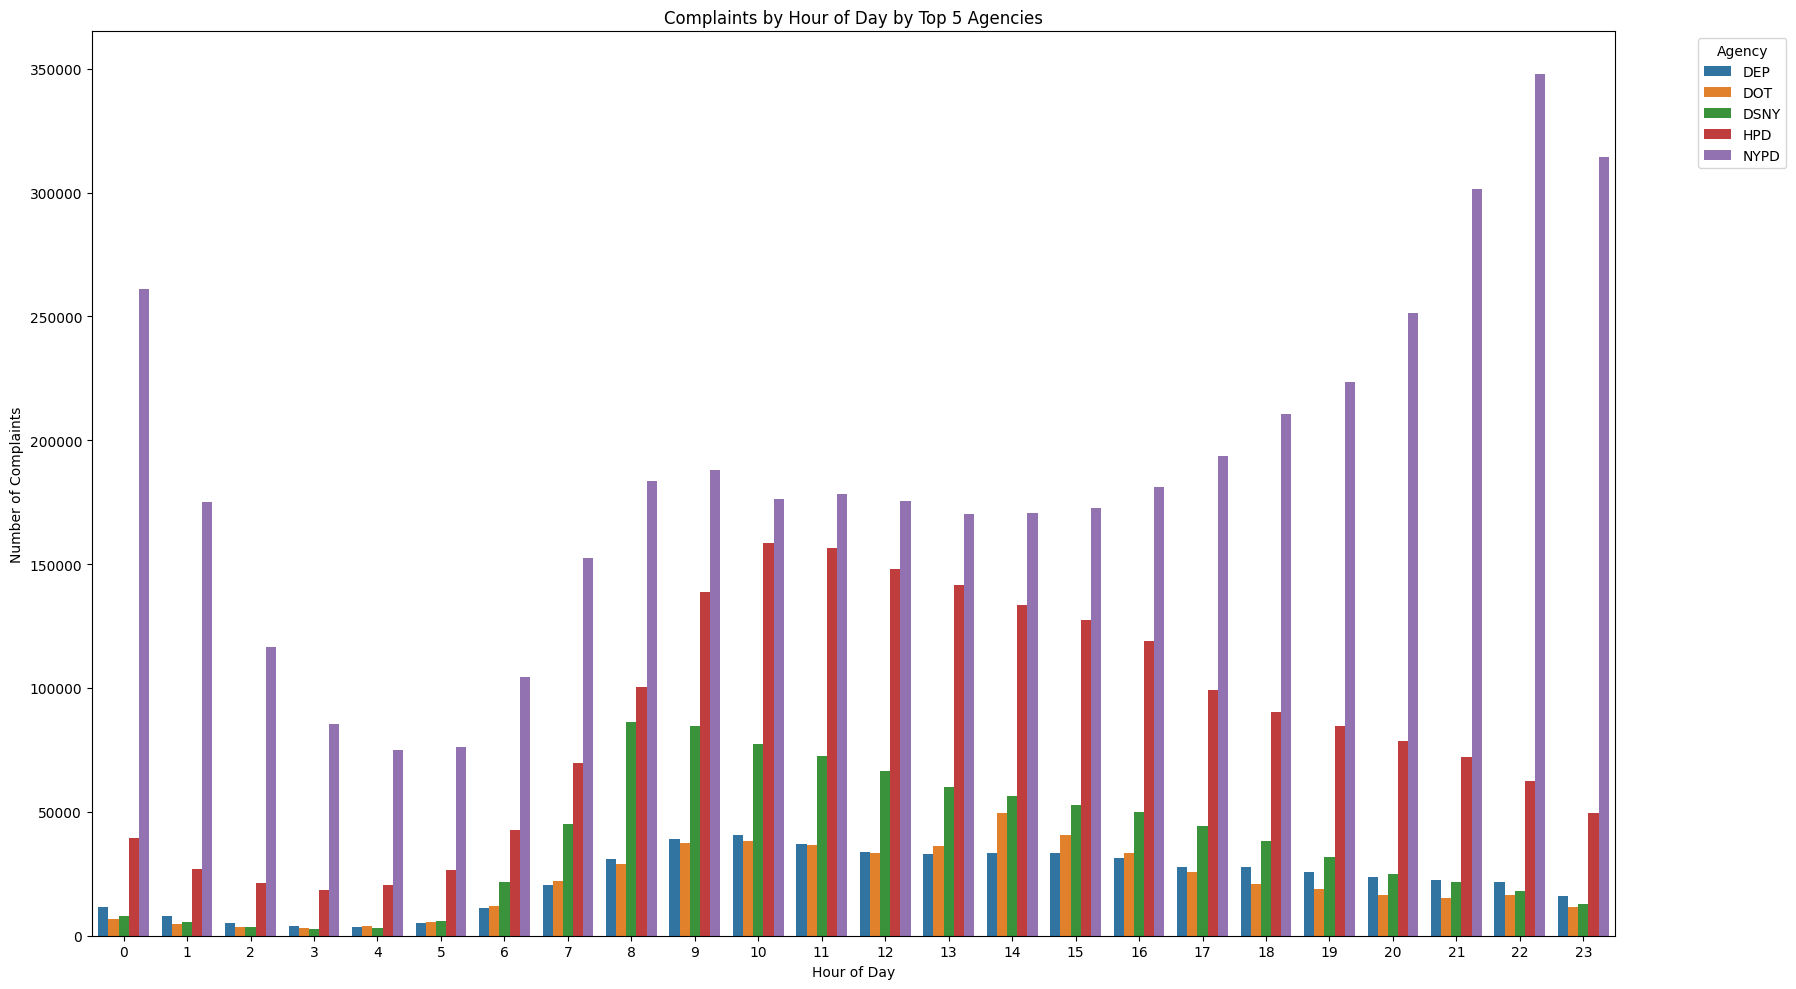

In [11]:
# Complaints by Hour of Day by Top 5 Agencies
top_agencies = (
    df["agency"]
    .value_counts()
    .nlargest(5)
    .index
)

complaints_by_hour_agency = (
    df[df["agency"].isin(top_agencies)]
      .groupby(["agency", "hour"])
      .size()
      .reset_index(name="count")
      .sort_values(["agency", "hour"])
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 10))
sns.barplot(
    data=complaints_by_hour_agency,
    x="hour",
    y="count",
    hue="agency"
)

plt.title("Complaints by Hour of Day by Top 5 Agencies")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Complaints")
plt.legend(title="Agency", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

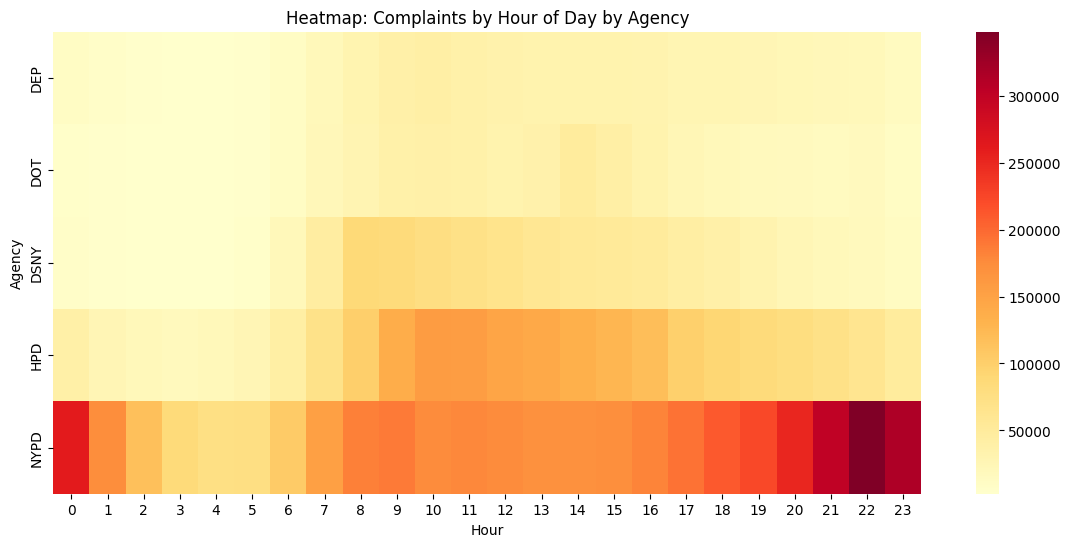

In [12]:
pivot = complaints_by_hour_agency.pivot(index="agency", columns="hour", values="count").fillna(0)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap="YlOrRd")
plt.title("Heatmap: Complaints by Hour of Day by Agency")
plt.xlabel("Hour")
plt.ylabel("Agency")
plt.show()


In [13]:
# Geospatial Heatmap of Rodent Complaints
complaint_choice = "Rodent"
subset = df[df["complaint_type"] == complaint_choice]

subset = subset.dropna(subset=["latitude", "longitude"])

m = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

HeatMap(
    data=subset[["latitude", "longitude"]].values,
    radius=10,
    blur=15,
    max_zoom=13
).add_to(m)

m

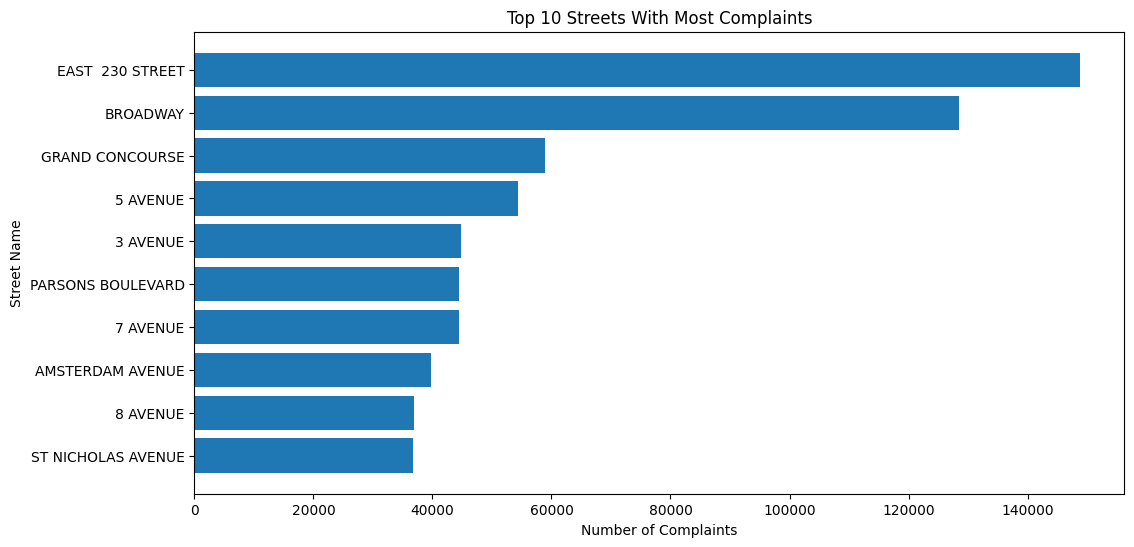

In [14]:
# Top 10 Streets With Most Complaints
df['street_name'] = df['street_name'].astype(str)

clean_street = df.loc[
    (df['street_name'].notna()) &
    (df['street_name'] != 'Unknown') &
    (df['street_name'].str.lower() != 'nan') &
    (df['street_name'].str.strip() != '')
]

street_counts = (
    clean_street['street_name']
    .value_counts()
    .head(10)
    .reset_index()
)

street_counts.columns = ['street_name', 'complaint_count']

plt.figure(figsize=(12,6))
plt.barh(street_counts['street_name'], street_counts['complaint_count'])
plt.title("Top 10 Streets With Most Complaints")
plt.xlabel("Number of Complaints")
plt.ylabel("Street Name")
plt.gca().invert_yaxis()
plt.show()


In [15]:
# Categorical columns in the dataset
cat_cols = [
    "agency",
    "complaint_type",
    "descriptor",
    "borough",
    "location_type",
    "city",
    "incident_address",
    "street_name",
    "incident_zip",
    "status"
]

cat_cols


['agency',
 'complaint_type',
 'descriptor',
 'borough',
 'location_type',
 'city',
 'incident_address',
 'street_name',
 'incident_zip',
 'status']

In [16]:
df["created_date"] = pd.to_datetime(df["created_date"])
# Dropping edge dates
dates_to_remove = [
    pd.to_datetime("2022-11-23"),
    pd.to_datetime("2025-11-10")
]

df = df[~df["created_date"].dt.normalize().isin(dates_to_remove)]

In [17]:
# Label Encoding categorical variables
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

df.head()

unique_key        created_date          closed_date  year  month  \
290    66777749 2025-11-09 23:59:57  2025-11-10 00:00:51  2025     11   
291    66777757 2025-11-09 23:59:42  2025-11-10 00:29:21  2025     11   
292    66773813 2025-11-09 23:59:32  2025-11-10 01:31:21  2025     11   
293    66775234 2025-11-09 23:59:30                  NaN  2025     11   
294    66772624 2025-11-09 23:59:00  2025-11-10 01:49:19  2025     11   

     dayofweek  hour  agency  complaint_type  descriptor  borough  \
290          6    23      12             126         557        0   
291          6    23      12             126         557        2   
292          6    23      12             122         557        3   
293          6    23      12              96          85        1   
294          6    23      12              96          86        0   

     location_type  city  incident_address  street_name  incident_zip  \
290            107     6            182700        13043           109   
291            107    47            147258          684            27   
292             32    20             42005          837           210   
293            140     7             67171         5158           154   
294            140     6            296154        13569           106   

      latitude  longitude  days_to_close  status  \
290  40.836941 -73.903744            0.0       1   
291  40.798815 -73.947799            0.0       1   
292  40.719544 -73.842507            0.0       1   
293  40.661958 -73.860960            NaN       2   
294  40.854459 -73.915981            0.0       1   

                                    location  
290  (40.83694066292417, -73.90374441298103)  
291  (40.79881467021513, -73.94779857268328)  
292  (40.71954389017692, -73.84250686995416)  
293  (40.66195761653244, -73.86096039477249)  
294  (40.85445871431665, -73.91598056093478)

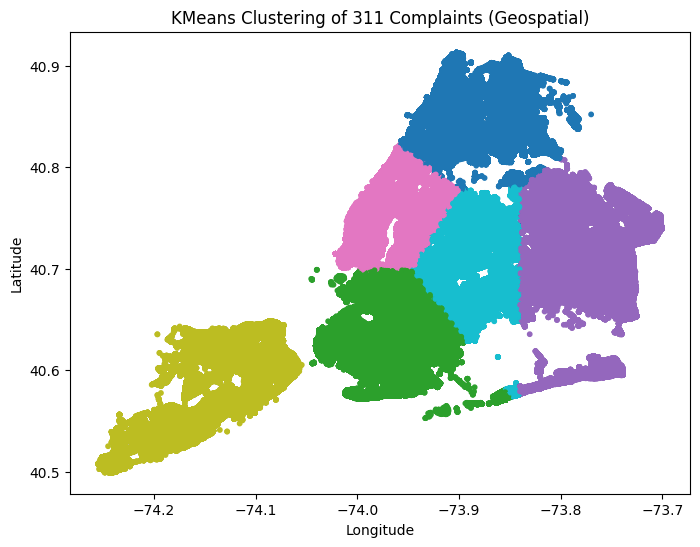

In [18]:
# KMeans Clustering on Geospatial Data
df_geo = df.dropna(subset=["latitude", "longitude"])

coords = df_geo[["latitude", "longitude"]]

k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_geo["cluster"] = kmeans.fit_predict(coords)

plt.figure(figsize=(8, 6))
plt.scatter(
    df_geo["longitude"], 
    df_geo["latitude"], 
    c=df_geo["cluster"], 
    cmap="tab10",
    s=10
)
plt.title("KMeans Clustering of 311 Complaints (Geospatial)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [19]:
# KMeans Clustering on Complaint Types by Zip Code
complaint_matrix = (
    df.groupby(["incident_zip", "complaint_type"])
      .size()
      .unstack(fill_value=0)
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(complaint_matrix)

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
complaint_matrix["cluster"] = kmeans.fit_predict(X_scaled)


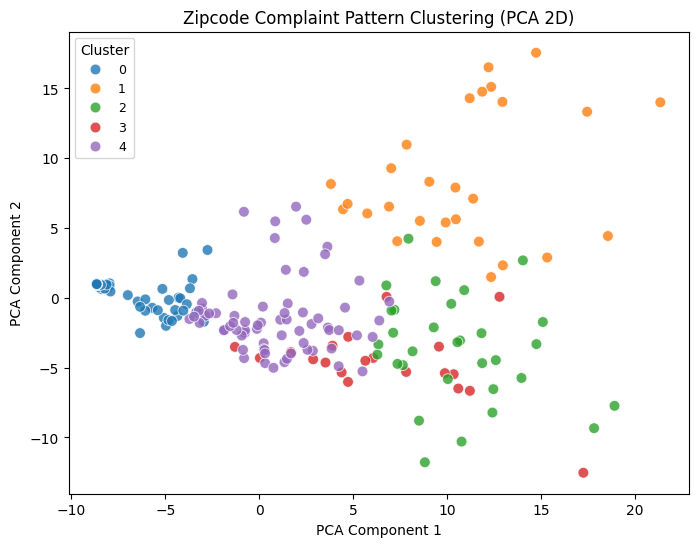

In [20]:
# PCA for 2D Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

complaint_matrix["pca1"] = pca_result[:, 0]
complaint_matrix["pca2"] = pca_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=complaint_matrix,
    x="pca1",
    y="pca2",
    hue="cluster",
    palette="tab10",
    s=60,
    alpha=0.8
)

plt.title("Zipcode Complaint Pattern Clustering (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", fontsize=9)
plt.show()


In [21]:
df["created_date"] = pd.to_datetime(df["created_date"])

daily_counts = (
    df.groupby(df["created_date"].dt.date)
      .size()
      .reset_index(name="count")
)

daily_counts["created_date"] = pd.to_datetime(daily_counts["created_date"])
daily_counts.head()

created_date  count
0   2022-11-24   5259
1   2022-11-25   5705
2   2022-11-26   6248
3   2022-11-27   6024
4   2022-11-28   8338

In [22]:
ts = daily_counts.rename(columns={"created_date": "ds", "count": "y"})
train = ts.copy()

In [23]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True
)

model.fit(train)

02:02:09 - cmdstanpy - INFO - Chain [1] start processing
02:02:09 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

In [25]:
fig = plot_plotly(model, forecast)
fig.show()

In [26]:
# Forecasting for Each Complaint Type
complaint_types = df['complaint_type'].unique()

forecasts = {}

for c in complaint_types:

    temp = df[df['complaint_type'] == c].copy()

    if temp.empty:

        continue

    ts = (
        temp
        .groupby(temp['created_date'].dt.date)
        .size()
        .reset_index(name='y')
    )
    ts.rename(columns={'created_date': 'ds'}, inplace=True)

    ts['ds'] = pd.to_datetime(ts['ds'])

    if ts['y'].count() < 2:

        continue

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=True
    )
    model.fit(ts)

    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    forecasts[c] = forecast

02:02:21 - cmdstanpy - INFO - Chain [1] start processing
02:02:21 - cmdstanpy - INFO - Chain [1] done processing
02:02:24 - cmdstanpy - INFO - Chain [1] start processing
02:02:24 - cmdstanpy - INFO - Chain [1] done processing
02:02:29 - cmdstanpy - INFO - Chain [1] start processing
02:02:29 - cmdstanpy - INFO - Chain [1] done processing
02:02:31 - cmdstanpy - INFO - Chain [1] start processing
02:02:31 - cmdstanpy - INFO - Chain [1] done processing
02:02:33 - cmdstanpy - INFO - Chain [1] start processing
02:02:34 - cmdstanpy - INFO - Chain [1] done processing
02:02:35 - cmdstanpy - INFO - Chain [1] start processing
02:02:35 - cmdstanpy - INFO - Chain [1] done processing
02:02:37 - cmdstanpy - INFO - Chain [1] start processing
02:02:37 - cmdstanpy - INFO - Chain [1] done processing
02:02:39 - cmdstanpy - INFO - Chain [1] start processing
02:02:39 - cmdstanpy - INFO - Chain [1] done processing
02:02:40 - cmdstanpy - INFO - Chain [1] start processing
02:02:40 - cmdstanpy - INFO - Chain [1]

In [27]:
c = 87
model = Prophet().fit(
    df[df['complaint_type'] == c]
      .groupby(df['created_date'].dt.date).size()
      .reset_index(name='y')
      .rename(columns={'created_date':'ds'})
      .assign(ds=lambda x: pd.to_datetime(x['ds']))
)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

figu = plot_plotly(model, forecast)
figu.show()

02:04:55 - cmdstanpy - INFO - Chain [1] start processing
02:04:56 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Preparing Data for Predictive Modeling
df_closed = df[
    df["days_to_close"].notna() & (df["days_to_close"] <= 100)
].copy()

datetime_cols = ["created_date", "closed_date", "unique_key", "location", "status", "descriptor"]

X = df_closed.drop(columns=["days_to_close"] + datetime_cols)
y = df_closed["days_to_close"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_cols = ["year", "month", "dayofweek", "hour", "latitude", "longitude"]

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [30]:
models = {
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        enable_categorical=True
    ),

    "CatBoost": CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=8,
        loss_function="RMSE",
        random_state=42,
        verbose=False
    ),

    "LightGBM": LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="regression",
        random_state=42,
        n_jobs=-1
    ),

    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

    # "MLP (Neural Net)": MLPRegressor(
    #     hidden_layer_sizes=(128, 64),
    #     activation="relu",
    #     solver="adam",
    #     learning_rate_init=0.001,
    #     max_iter=500,
    #     random_state=42
    # )
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append([name, rmse, r2])

results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R²"]).sort_values("RMSE")
print("\n----Model Performance Comparison----")
print(results_df)



Training XGBoost...

Training CatBoost...

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1605
[LightGBM] [Info] Number of data points in the train set: 7413205, number of used features: 14
[LightGBM] [Info] Start training from score 4.673062

Training RandomForestRegressor...

----Model Performance Comparison----
                   Model      RMSE        R²
0                XGBoost  9.329125  0.495569
2               LightGBM  9.493226  0.477667
1               CatBoost  9.583641  0.467670
3  RandomForestRegressor  9.682319  0.456651


/var/folders/3l/skzqjx4536sg_944vc9xb1j80000gn/T/ipykernel_67620/479077178.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/3l/skzqjx4536sg_944vc9xb1j80000gn/T/ipykernel_67620/479077178.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




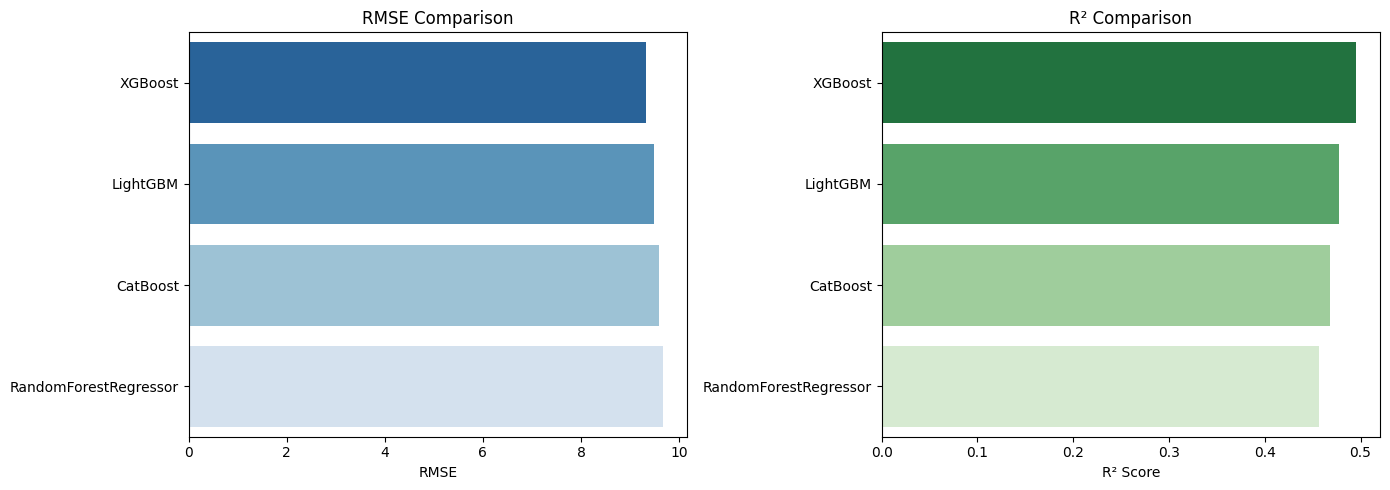

In [31]:
# RMSE and R² Bar Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(
    x="RMSE",
    y="Model",
    data=results_df.sort_values("RMSE"),
    palette="Blues_r",
    ax=axes[0]
)
axes[0].set_title("RMSE Comparison")
axes[0].set_xlabel("RMSE")
axes[0].set_ylabel("")

sns.barplot(
    x="R²",
    y="Model",
    data=results_df.sort_values("R²", ascending=False),
    palette="Greens_r",
    ax=axes[1]
)
axes[1].set_title("R² Comparison")
axes[1].set_xlabel("R² Score")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [32]:
N_TUNE = 300_000
rng = np.random.RandomState(42)
idx = rng.choice(X_train.index, size=min(N_TUNE, len(X_train)), replace=False)

X_tune = X_train.loc[idx]
y_tune = y_train.loc[idx]

X_tr, X_val, y_tr, y_val = train_test_split(
    X_tune, y_tune, test_size=0.2, random_state=42
)

param_grid = {
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5],
}

best_rmse = float("inf")
best_params = None

for params in ParameterGrid(param_grid):
    model = XGBRegressor(
        n_estimators=5000,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )

    model.set_params(**params)

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    pred_val = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred_val))

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best params (tuning sample):", best_params)
print("Best validation RMSE:", best_rmse)

final_model = XGBRegressor(
    n_estimators=5000,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    **best_params
)

final_model.fit(X_train, y_train, verbose=False)

y_pred = final_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print("\n---- Final XGBoost Test Performance ----")
print("RMSE:", rmse_test)
print("R²:", r2_test)


Best params (tuning sample): {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 1.0}
Best validation RMSE: 9.600570516914406

---- Final XGBoost Test Performance ----
RMSE: 9.481091526094248
R²: 0.4790013280604143


In [33]:
# Chi-Square Test for Borough vs. Complaint Type
df_contrast = df.copy()
df_contrast['borough_decoded'] = label_encoders['borough'].inverse_transform(df_contrast['borough'])
df_contrast['complaint_type_decoded'] = label_encoders['complaint_type'].inverse_transform(df_contrast['complaint_type'])

df_cp = df_contrast[['borough_decoded', 'complaint_type_decoded']].dropna()

ct = pd.crosstab(df_cp['borough_decoded'], df_cp['complaint_type_decoded'])

chi2, p, dof, expected = chi2_contingency(ct)

print("Chi-square statistic:", chi2)
print("p-value:", p)

expected_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)

residuals = (ct - expected_df) / expected_df.pow(0.5)

top_contrasts = {}

for borough in residuals.index:
    sorted_vals = residuals.loc[borough].sort_values(ascending=False)
    top_contrasts[borough] = sorted_vals.head(10)

for borough, vals in top_contrasts.items():
    print(f"\n=== Top Contrast Complaint Types for {borough} ===")
    print(vals)


Chi-square statistic: 2521896.5748881423
p-value: 0.0

=== Top Contrast Complaint Types for BRONX ===
complaint_type_decoded
Noise - Residential        321.124315
HEAT/HOT WATER             286.595035
UNSANITARY CONDITION       151.668422
PAINT/PLASTER              144.698966
PLUMBING                   127.376081
Elevator                   110.500248
DOOR/WINDOW                107.893050
WATER LEAK                  97.600969
Noise - Street/Sidewalk     91.895760
FLOORING/STAIRS             91.733941
Name: BRONX, dtype: float64

=== Top Contrast Complaint Types for BROOKLYN ===
complaint_type_decoded
Illegal Parking                  182.279943
Graffiti                          85.351948
Blocked Driveway                  81.117980
Street Sweeping Complaint         73.664996
General Construction/Plumbing     60.749305
Rodent                            40.475032
Lead                              40.223340
Missed Collection                 39.069508
Real Time Enforcement             36.4483

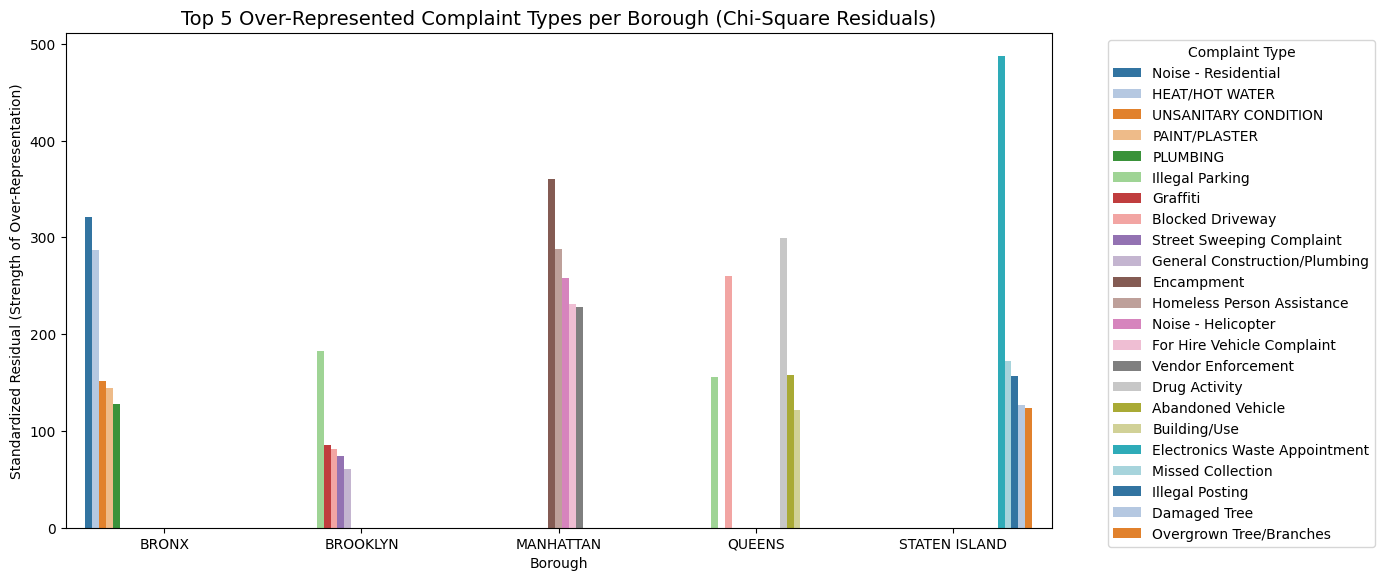

In [34]:
# Extract top 5 contrast complaints per borough
residuals_filtered = residuals.drop(index="Unspecified")

top5_list = []

for borough in residuals_filtered.index:
    top5 = residuals_filtered.loc[borough].sort_values(ascending=False).head(5)
    for complaint, score in top5.items():
        top5_list.append({
            "borough": borough,
            "complaint_type": complaint,
            "residual_score": score
        })

top5_df = pd.DataFrame(top5_list)

plt.figure(figsize=(14, 6))
sns.barplot(
    data=top5_df,
    x="borough",
    y="residual_score",
    hue="complaint_type",
    palette="tab20"
)

plt.title("Top 5 Over-Represented Complaint Types per Borough (Chi-Square Residuals)", fontsize=14)
plt.xlabel("Borough")
plt.ylabel("Standardized Residual (Strength of Over-Representation)")
plt.legend(title="Complaint Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [35]:
# Frequent Sequential Complaint Pairs by Location
df_seq = df.copy()
df_seq["created_date"] = pd.to_datetime(df_seq["created_date"])

df_seq["lat_round"] = df_seq["latitude"].round(4)
df_seq["lon_round"] = df_seq["longitude"].round(4)
df_seq["location_id"] = df_seq["lat_round"].astype(str) + "_" + df_seq["lon_round"].astype(str)

df_seq = df_seq.sort_values(["location_id", "created_date"])

sequences = df_seq.groupby("location_id")["complaint_type"].apply(list)

pair_counts = Counter()

for seq in sequences:
    for i in range(len(seq) - 1):
        a, b = seq[i], seq[i+1]

        if a == b:
            continue

        pair = tuple(sorted([a, b]))

        pair_counts[pair] += 1

pair_df = (
    pd.DataFrame([(a, b, c) for (a, b), c in pair_counts.items()],
                 columns=["complaint_1", "complaint_2", "count"])
    .sort_values("count", ascending=False)
)

complaint_le = label_encoders["complaint_type"]

pair_df["complaint_1_label"] = complaint_le.inverse_transform(pair_df["complaint_1"])
pair_df["complaint_2_label"] = complaint_le.inverse_transform(pair_df["complaint_2"])

pair_df.head(20)[["complaint_1", "complaint_2", "complaint_1_label", "complaint_2_label", "count"]]


complaint_1  complaint_2           complaint_1_label  \
82             18           96            Blocked Driveway   
81            126          127         Noise - Residential   
73             96          126             Illegal Parking   
128            87          126              HEAT/HOT WATER   
15              4           96           Abandoned Vehicle   
132            87          197              HEAT/HOT WATER   
890           137          197               PAINT/PLASTER   
102            96          127             Illegal Parking   
630            87          138              HEAT/HOT WATER   
133           138          197                    PLUMBING   
480            51           96           Derelict Vehicles   
331           127          128     Noise - Street/Sidewalk   
894           197          210        UNSANITARY CONDITION   
83             87           96              HEAT/HOT WATER   
184            18          126            Blocked Driveway   
706            44          197                 DOOR/WINDOW   
1704           78           96  For Hire Vehicle Complaint   
290           137          210               PAINT/PLASTER   
367            52           96             Dirty Condition   
1143          137          138               PAINT/PLASTER   

            complaint_2_label   count  
82            Illegal Parking  120747  
81    Noise - Street/Sidewalk   87482  
73        Noise - Residential   80455  
128       Noise - Residential   68740  
15            Illegal Parking   64299  
132      UNSANITARY CONDITION   61282  
890      UNSANITARY CONDITION   58751  
102   Noise - Street/Sidewalk   56737  
630                  PLUMBING   49157  
133      UNSANITARY CONDITION   44595  
480           Illegal Parking   44138  
331           Noise - Vehicle   39891  
894                WATER LEAK   38891  
83            Illegal Parking   38213  
184       Noise - Residential   38074  
706      UNSANITARY CONDITION   36143  
1704          Illegal Parking   34183  
290                WATER LEAK   33610  
367           Illegal Parking   30547  
1143                 PLUMBING   30087

<Figure size 1000x1000 with 0 Axes>

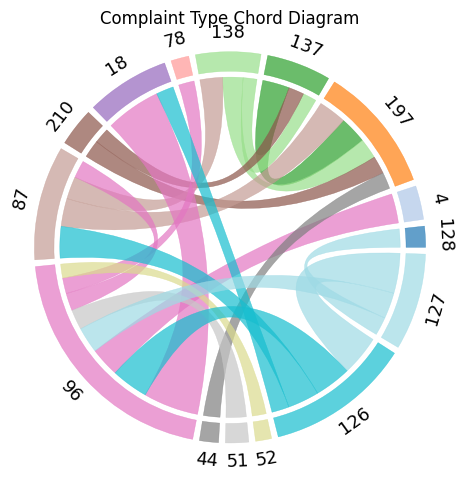

In [36]:
# Chord Diagram of Top Complaint Pairs
pairs = pair_df.head(20)

labels = list(set(pairs["complaint_1"]) | set(pairs["complaint_2"]))
labels = list(labels)

N = len(labels)
matrix = np.zeros((N, N))

for _, row in pairs.iterrows():
    i = labels.index(row["complaint_1"])
    j = labels.index(row["complaint_2"])
    matrix[i, j] = row["count"]
    matrix[j, i] = row["count"]

plt.figure(figsize=(10, 10))
chord_diagram(
    matrix,
    labels,
    cmap='tab20',
    chordwidth=0.7,
)

plt.title("Complaint Type Chord Diagram")
plt.show()


In [37]:
# Sankey Diagram of Top Complaint Pairs
pairs = pair_df.head(20)

labels = list(set(pairs["complaint_1_label"]) | set(pairs["complaint_2_label"]))
labels = list(labels)

src = [labels.index(a) for a in pairs["complaint_1_label"]]
dst = [labels.index(b) for b in pairs["complaint_2_label"]]
val = pairs["count"].tolist()

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=25,
        label=labels
    ),
    link=dict(
        source=src,
        target=dst,
        value=val
    )
)])

fig.update_layout(
    title="Complaint Pair Flow Diagram (Sankey Version)",
    width=1000,
    height=800)
fig.show()


In [38]:
df_temp = df.copy()
df_temp["created_date"] = pd.to_datetime(df_temp["created_date"])

daily = df_temp.groupby(df_temp["created_date"].dt.date).size()


In [39]:
# Burst Detection in Complaint Time Series
daily = daily.sort_index()
ts = daily

rolling_mean = ts.rolling(window=7).mean()
rolling_std = ts.rolling(window=7).std()

threshold = rolling_mean + 1.4 * rolling_std

bursts = ts[ts > threshold]

print("Detected spikes in complaint activity:")
print(bursts)

Detected spikes in complaint activity:
created_date
2022-12-12     9215
2022-12-24    10731
2023-01-17     8980
2023-02-03     9724
2023-02-04    10818
              ...  
2025-08-28     9378
2025-09-22    11198
2025-10-13    11142
2025-10-16    12420
2025-10-27    12169
Length: 75, dtype: int64


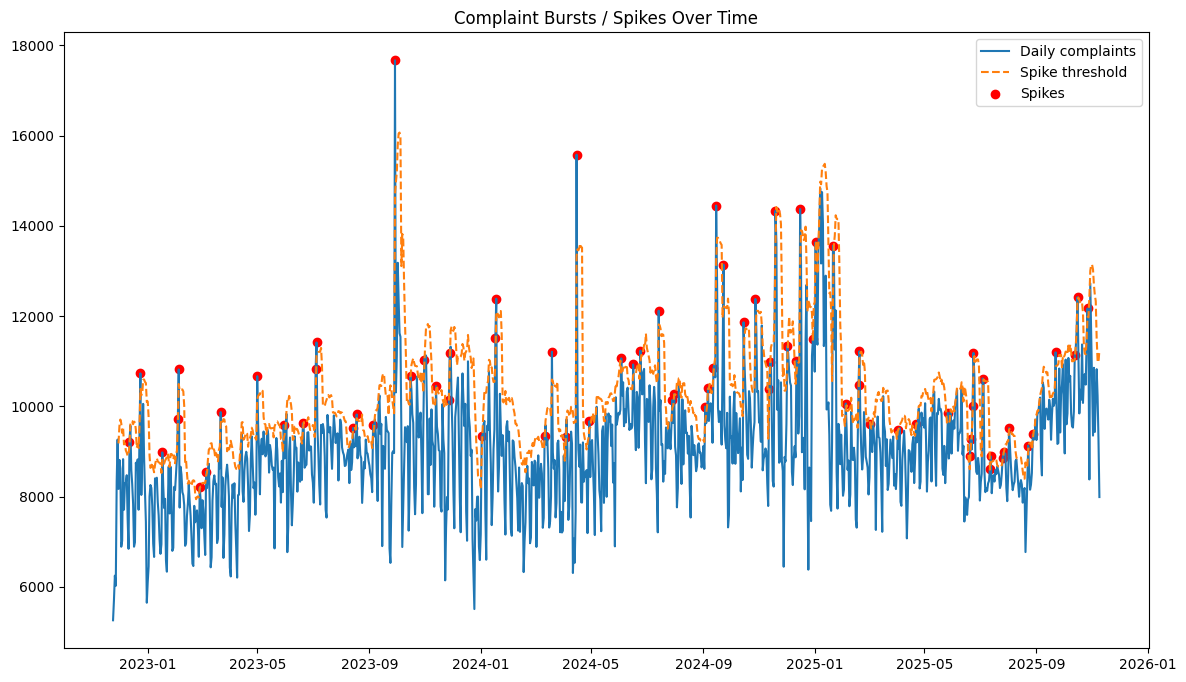

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
plt.plot(ts.index, ts.values, label="Daily complaints")
plt.plot(threshold.index, threshold.values, label="Spike threshold", linestyle="--")
plt.scatter(bursts.index, bursts.values, color="red", label="Spikes")
plt.legend()
plt.title("Complaint Bursts / Spikes Over Time")
plt.show()


In [41]:
# Burst Detection for Specific Complaint Type
df_temp["date"] = df_temp["created_date"].dt.date

complaint_daily = df_temp.groupby(["complaint_type", "date"]).size().reset_index(name="count")

def detect_spikes_for_type(ctype):
    sub = complaint_daily[complaint_daily["complaint_type"] == ctype]
    ts = sub.set_index("date")["count"].sort_index()

    rolling_mean = ts.rolling(window=7).mean()
    rolling_std = ts.rolling(window=7).std()
    threshold = rolling_mean + 1.4 * rolling_std
    
    bursts = ts[ts > threshold]
    return bursts

print(detect_spikes_for_type(87))


date
2022-12-01    1605
2022-12-09    1516
2022-12-10    1802
2022-12-13    2383
2022-12-23    2394
              ... 
2025-10-13    1288
2025-10-16    2432
2025-10-24    1729
2025-10-27    2582
2025-11-06    2032
Name: count, Length: 118, dtype: int64


In [42]:
# Daily Counts per Complaint Type
df["created_date"] = pd.to_datetime(df["created_date"])

daily = (
    df.groupby([pd.Grouper(key="created_date", freq="D"), "complaint_type"])
      .size()
      .reset_index(name="count")
)

daily.head(10)

created_date  complaint_type  count
0   2022-11-24               1     18
1   2022-11-24               3      3
2   2022-11-24               4     75
3   2022-11-24               6     15
4   2022-11-24               8      3
5   2022-11-24               9     22
6   2022-11-24              18    521
7   2022-11-24              20      3
8   2022-11-24              23      2
9   2022-11-24              28     17

In [43]:
# Burst Detection for Each Complaint Type
WINDOW = 7
Z_THRESHOLD = 1.4

daily = daily.sort_values("created_date")

daily["rolling_mean"] = (
    daily.groupby("complaint_type")["count"]
         .transform(lambda x: x.rolling(WINDOW, min_periods=7).mean())
)

daily["rolling_std"] = (
    daily.groupby("complaint_type")["count"]
         .transform(lambda x: x.rolling(WINDOW, min_periods=7).std())
)

daily["z_score"] = (daily["count"] - daily["rolling_mean"]) / daily["rolling_std"]

daily["anomaly"] = daily["z_score"] > Z_THRESHOLD

daily_anomalies = daily[daily["anomaly"] == True]
daily_anomalies.head(20)


created_date  complaint_type  count  rolling_mean  rolling_std   z_score  \
765   2022-11-30             134     21     12.285714     5.056820  1.723274   
766   2022-11-30             136     47     18.857143    16.242214  1.732698   
762   2022-11-30             130      4      1.857143     1.214986  1.763689   
794   2022-11-30             194    216     92.285714    60.681448  2.038750   
788   2022-11-30             183     15      6.571429     5.255383  1.603798   
787   2022-11-30             182     15      8.285714     4.572173  1.468511   
782   2022-11-30             170     17     10.571429     3.866831  1.662491   
713   2022-11-30              49     28     11.714286     8.400680  1.938619   
710   2022-11-30              46    202     54.000000    67.771675  2.183803   
722   2022-11-30              65     11      5.571429     3.309438  1.640330   
879   2022-12-01             130     11      3.285714     3.592320  2.147438   
865   2022-12-01             112     30     18.714286     7.952238  1.419187   
911   2022-12-01             198      7      3.714286     1.976047  1.662771   
908   2022-12-01             193     17      7.000000     6.110101  1.636634   
906   2022-12-01             188     24     16.857143     4.488079  1.591518   
903   2022-12-01             182     29     12.285714     8.056349  2.074672   
897   2022-12-01             170     29     13.142857     7.988086  1.985099   
827   2022-12-01              49     33     16.000000    10.583005  1.606349   
822   2022-12-01              39     23     11.857143     6.718843  1.658449   
857   2022-12-01              98     16      8.857143     4.705620  1.517942   

     anomaly  
765     True  
766     True  
762     True  
794     True  
788     True  
787     True  
782     True  
713     True  
710     True  
722     True  
879     True  
865     True  
911     True  
908     True  
906     True  
903     True  
897     True  
827     True  
822     True  
857     True

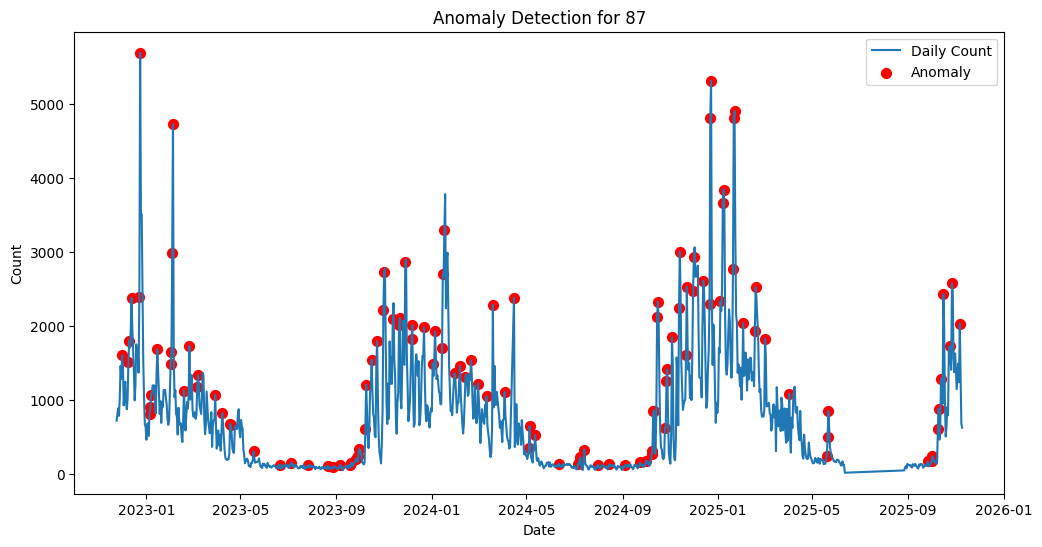

In [44]:
# Visualizing Anomalies for a Specific Complaint Type
complaint = 87

subset = daily[daily["complaint_type"] == complaint]

plt.figure(figsize=(12,6))
plt.plot(subset["created_date"], subset["count"], label="Daily Count")
plt.scatter(
    subset[subset["anomaly"] == True]["created_date"],
    subset[subset["anomaly"] == True]["count"],
    marker="o", s=50, color="red", label="Anomaly"
)
plt.title(f"Anomaly Detection for {complaint}")
plt.xlabel("Date")
plt.ylabel("Count")
plt.legend()
plt.show()
